In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings('ignore')

In [195]:
#data=pd.read_excel('Database_NIR_Theranostics.xlsx')
data=pd.read_excel('Database_NIR_Theranostics_12.19.xlsx')
data=data.dropna(subset=['SMILES'])

In [196]:
def get_maccs_fingerprint(smi):
    try:
        mol=Chem.MolFromSmiles(smi)
        fps = AllChem.GetMACCSKeysFingerprint(mol)
    except:
        fps=None
    return fps

def get_morgan_fp(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
        fp=list(fp)
    except:
        fp=None
    return fp

def get_Morgan_fingerprint_frequency(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=2048,bitInfo=info)
        key=[key for key in info.keys()]
        frq=[len(value) for value in info.values()]
        new_info={key: value for key, value in zip(key, frq)}
        mff=[0] * len(list(fp))
        for key, value in new_info.items():
            mff[key] = value
    except:
        mff=None
    return mff

In [197]:
data['maccs_fp']=data['SMILES'].apply(get_maccs_fingerprint)
data['morgan_fp']=data['SMILES'].apply(get_morgan_fp)
data['morgan_fp_frequency']=data['SMILES'].apply(get_Morgan_fingerprint_frequency)

In [198]:
data['dihedral angle'] = data['dihedral angle'].apply(
    lambda x: str(x).split('/')[0] if isinstance(x, str) else x
)
data['dihedral angle']=data['dihedral angle'].astype(float)

#### The correlation between dihedral angle and HLG (eV)

In [199]:
correlation = data['dihedral angle'].corr(data['HLG (eV)'])
print(f"The correlation between dihedral angle and HLG (eV) is: {correlation}")

The correlation between dihedral angle and HLG (eV) is: -0.5860574570182705


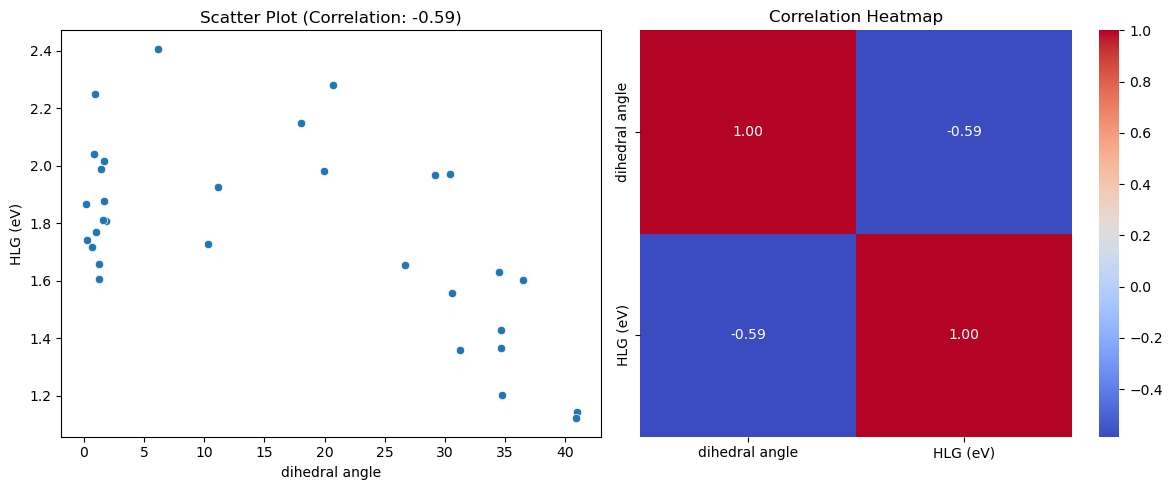

In [200]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 散点图
sns.scatterplot(x='dihedral angle', y='HLG (eV)', data=data, ax=ax[0])
ax[0].set_title(f'Scatter Plot (Correlation: {correlation:.2f})')
ax[0].set_xlabel('dihedral angle')
ax[0].set_ylabel('HLG (eV)')

# 热力图
correlation_matrix = data[['dihedral angle', 'HLG (eV)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
ax[1].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()

In [201]:
def convert_and_merge(row):
    bitvect_as_list = list(row['maccs_fp'].ToBitString()) 
    bitvect_as_list = [int(bit) for bit in bitvect_as_list] 
    return bitvect_as_list + [row['dihedral angle']]

def convert_and_merge_v1(row):
    return row['morgan_fp'] + [row['dihedral angle']]

data['maccs_fp_angle'] = data.apply(convert_and_merge, axis=1)
data['morgan_fp_angle'] = data.apply(convert_and_merge_v1, axis=1)

#### ML Part
Use molecule fingerprint as input, to predict the HLG (eV)

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import KFold

In [203]:
X = np.array(data['maccs_fp'].tolist())  
y = np.array(data['HLG (eV)'])  

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, mae_list = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print average results
print('5-Fold Cross-Validation Results:')
print('Average MSE:', np.mean(mse_list))
print('Average R2 score:', np.mean(r2_list))
print('Average MAE:', np.mean(mae_list))

5-Fold Cross-Validation Results:
Average MSE: 0.07185920131295723
Average R2 score: -0.07147858582320685
Average MAE: 0.2226765153865083


In [204]:
X = np.array(data['morgan_fp'].tolist())  
y = np.array(data['HLG (eV)'])  

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, mae_list = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print average results
print('5-Fold Cross-Validation Results:')
print('Average MSE:', np.mean(mse_list))
print('Average R2 score:', np.mean(r2_list))
print('Average MAE:', np.mean(mae_list))

5-Fold Cross-Validation Results:
Average MSE: 0.0700637126485641
Average R2 score: 0.03953685574399039
Average MAE: 0.22569498906031762


#### Add dihedral angle
Use molecule fingerprint and dihedral angle as input, to predict the HLG (eV)

In [205]:
data=data.dropna(subset=['dihedral angle'])

In [206]:
X = np.array(data['maccs_fp_angle'].tolist())  
y = np.array(data['HLG (eV)'])  

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=159)
mse_list, r2_list, mae_list = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print average results
print('5-Fold Cross-Validation Results:')
print('Average MSE:', np.mean(mse_list))
print('Average R2 score:', np.mean(r2_list))
print('Average MAE:', np.mean(mae_list))

5-Fold Cross-Validation Results:
Average MSE: 0.02450858875245359
Average R2 score: 0.72439899193245
Average MAE: 0.1300290232380951


In [207]:
X = np.array(data['morgan_fp_angle'].tolist())  
y = np.array(data['HLG (eV)'])  

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=153)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list, r2_list, mae_list = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print average results
print('5-Fold Cross-Validation Results:')
print('Average MSE:', np.mean(mse_list))
print('Average R2 score:', np.mean(r2_list))
print('Average MAE:', np.mean(mae_list))

5-Fold Cross-Validation Results:
Average MSE: 0.041761214522968285
Average R2 score: 0.5254499918087232
Average MAE: 0.16763539342857134


#### Analysis correlation

In [208]:
data=data.dropna(subset=['ST Gap/ΔEST (eV)'])

In [209]:
data['Absorbance'] = pd.to_numeric(data['Absorbance'], errors='coerce')

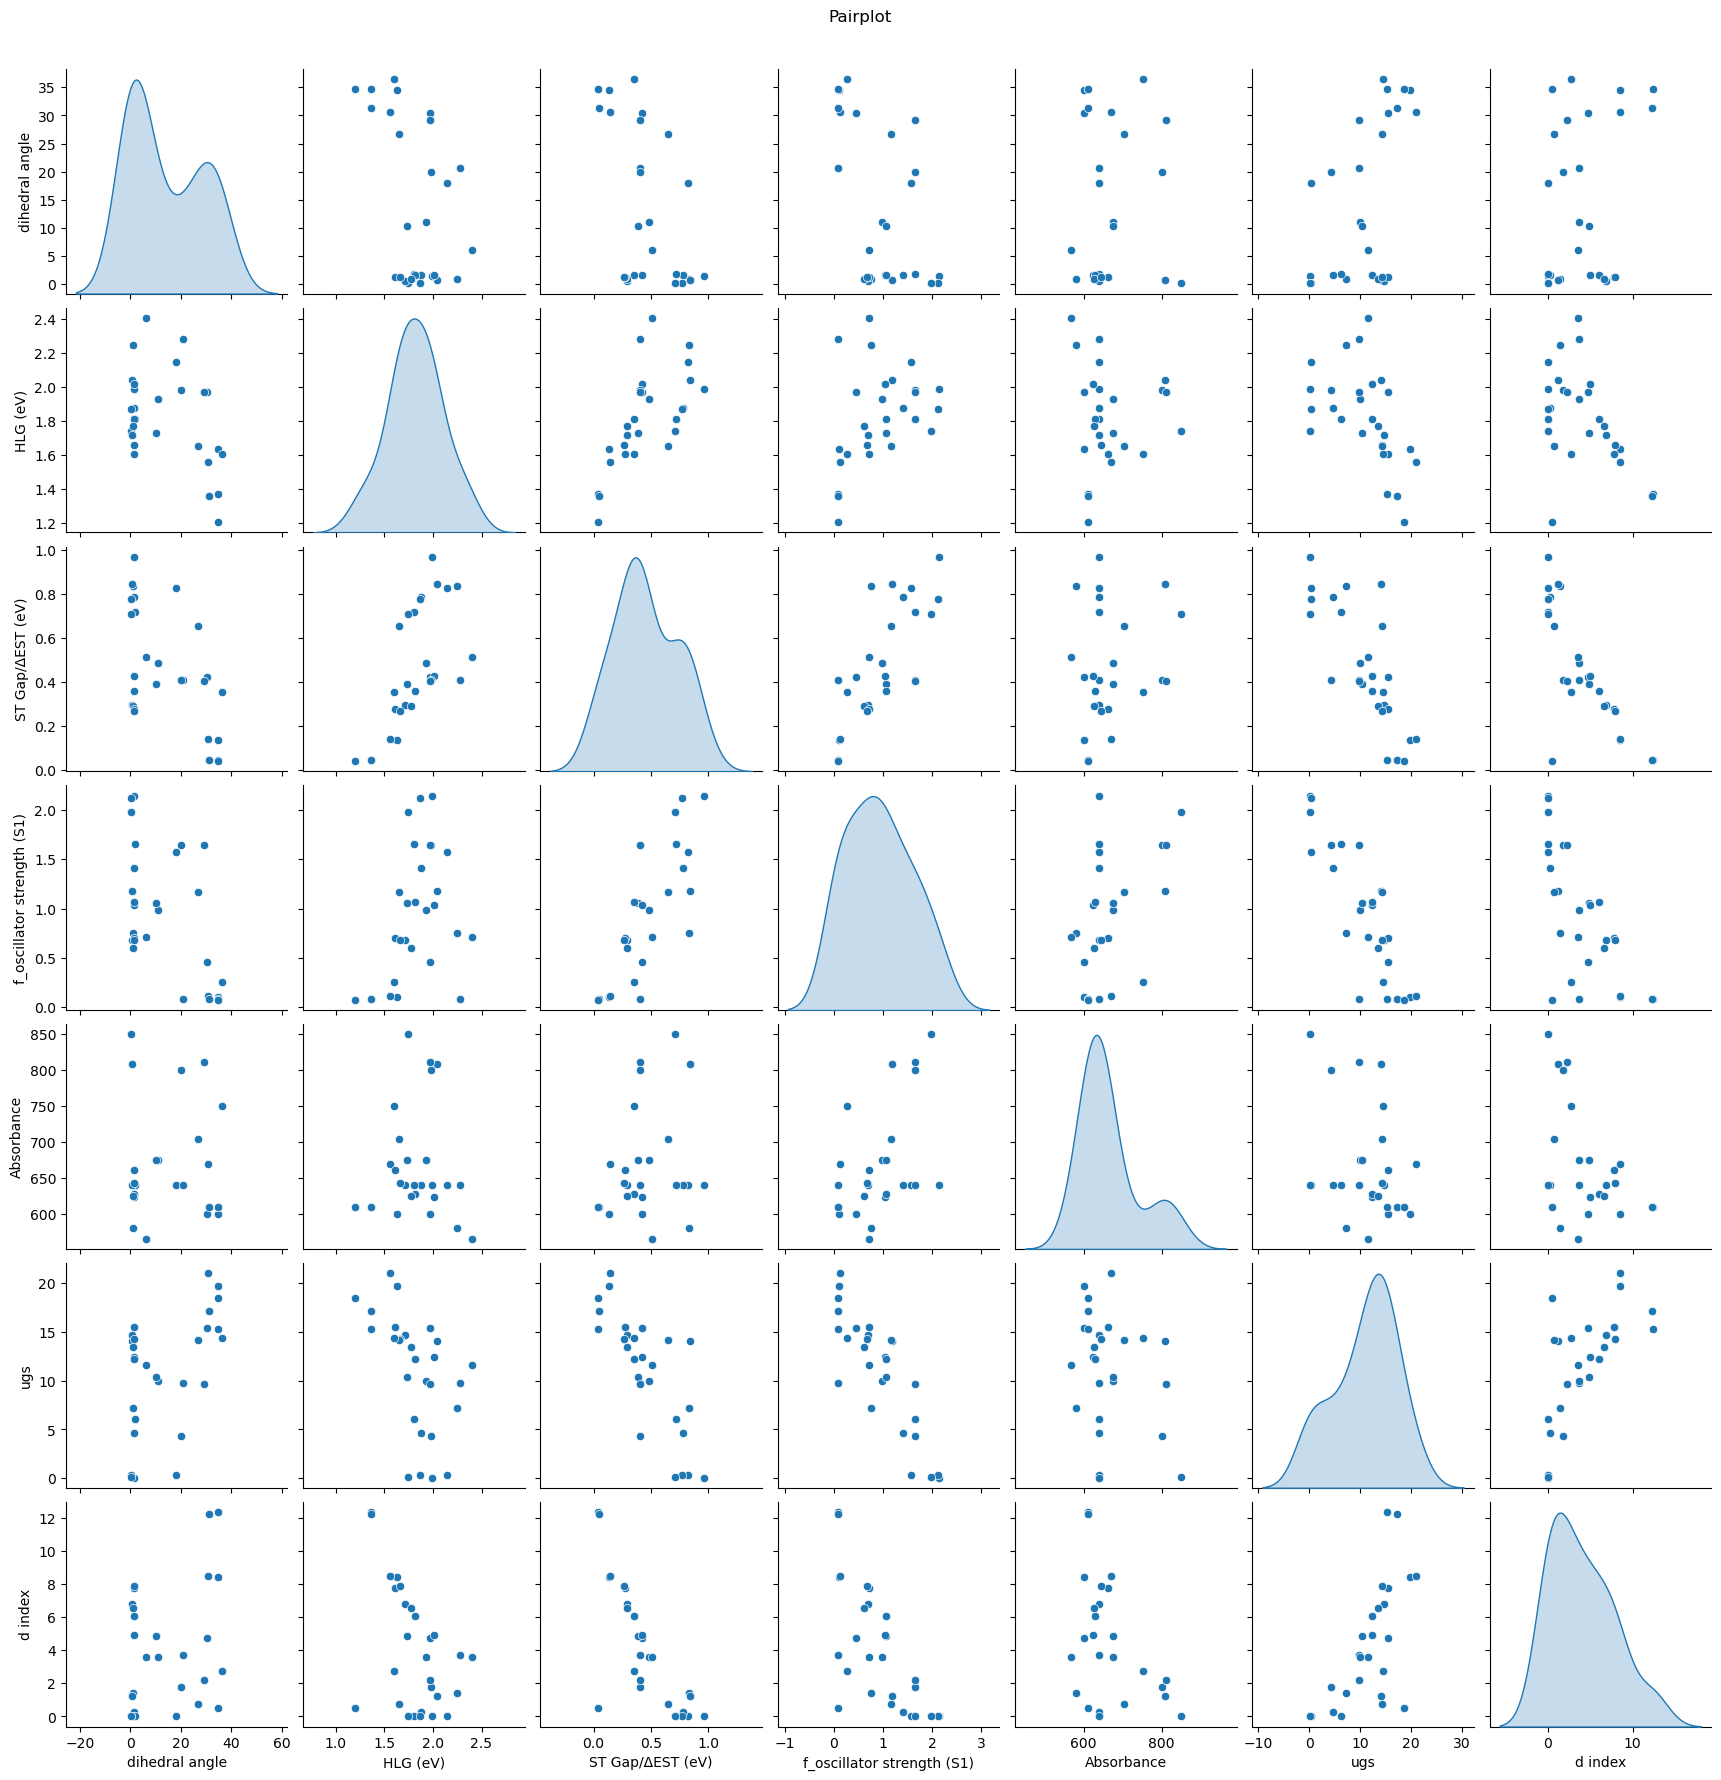

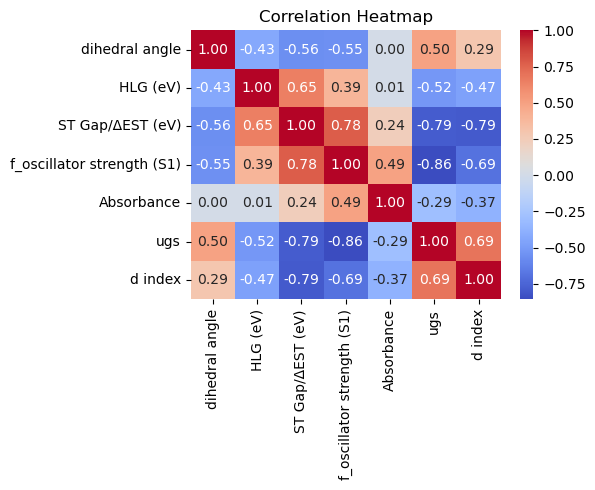

In [212]:
correlation_matrix = data[['dihedral angle', 'HLG (eV)', 'ST Gap/ΔEST (eV)','f_oscillator strength (S1)','Absorbance','ugs','d index']].corr()
# Pairplot 独立绘制
sns.pairplot(data[['dihedral angle', 'HLG (eV)', 'ST Gap/ΔEST (eV)','f_oscillator strength (S1)','Absorbance','ugs','d index']], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot", y=1.02)
plt.show()

# 热力图单独绘制
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [213]:
X = np.array(data['maccs_fp_angle'].tolist())  
y = np.array(data['ugs'])  

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=159)
mse_list, r2_list, mae_list = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)
    mae_list.append(mae)

# Print average results
print('5-Fold Cross-Validation Results:')
print('Average MSE:', np.mean(mse_list))
print('Average R2 score:', np.mean(r2_list))
print('Average MAE:', np.mean(mae_list))

5-Fold Cross-Validation Results:
Average MSE: 14.227362064010284
Average R2 score: 0.038226177799798755
Average MAE: 3.1257677400000023
